# Biomedical Image Analysis

In [146]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay

In [122]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    print(len(norm_images))
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    X_train = np.append(norm_images, pneu_images, axis=0)
    y_train = np.append(norm_labels, pneu_labels)
    
    return pneu_images, pneu_labels

In [123]:
norm_images, norm_labels = load_normal('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/train/PNEUMONIA/')

100%|██████████| 1341/1341 [00:28<00:00, 46.57it/s]


1341


100%|██████████| 3875/3875 [00:30<00:00, 125.99it/s]


In [124]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [125]:
def plot_images(X, y):
    fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

    indices = np.random.choice(len(X), 14)
    counter = 0

    for i in range(2):
        for j in range(7):
            axes[i,j].set_title(y[indices[counter]])
            axes[i,j].imshow(X[indices[counter]], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

In [126]:
norm_images_test, norm_labels_test = load_normal('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/test/PNEUMONIA/')

100%|██████████| 234/234 [00:04<00:00, 56.25it/s]


234


100%|██████████| 390/390 [00:02<00:00, 143.93it/s]


In [127]:
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

In [128]:
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [129]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345], dtype=int64))

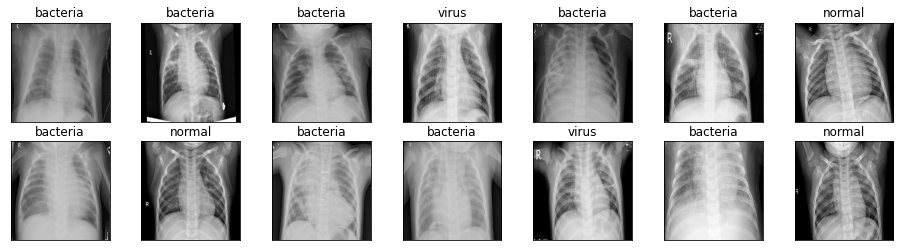

In [130]:
plot_images(X_train, y_train)

In [131]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345], dtype=int64))

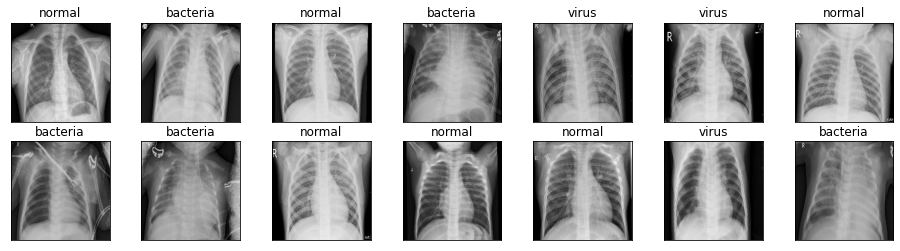

In [132]:
plot_images(X_test, y_test)

In [133]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
y_train

array([['normal'],
       ['normal'],
       ['normal'],
       ...,
       ['bacteria'],
       ['bacteria'],
       ['bacteria']], dtype='<U8')

In [134]:
y_test

array([['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['normal'],
       ['nor

In [135]:
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown = 'error')

In [136]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [137]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [138]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [139]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [140]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='sigmoid', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

In [141]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 200, 200, 16)      160       
                                                                 
 conv2d_19 (Conv2D)          (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 100, 100, 16)      2064      
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 32)      2080      
                                                          

In [142]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [143]:
history2 = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))

Epoch 1/30


C:\Users\anask\AppData\Local\Temp/ipykernel_17632/2115395957.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))


163/163 [==============================] - 124s 757ms/step - loss: 1.7789 - acc: 0.4206 - val_loss: 1.1401 - val_acc: 0.3878
Epoch 2/30
163/163 [==============================] - 122s 751ms/step - loss: 1.0617 - acc: 0.4822 - val_loss: 1.1351 - val_acc: 0.3878
Epoch 3/30
163/163 [==============================] - 121s 740ms/step - loss: 1.0618 - acc: 0.4827 - val_loss: 1.0873 - val_acc: 0.3878
Epoch 4/30
163/163 [==============================] - 122s 747ms/step - loss: 1.0601 - acc: 0.4845 - val_loss: 1.1182 - val_acc: 0.3878
Epoch 5/30
163/163 [==============================] - 120s 738ms/step - loss: 1.0533 - acc: 0.4831 - val_loss: 1.0932 - val_acc: 0.3878
Epoch 6/30
163/163 [==============================] - 121s 739ms/step - loss: 1.0524 - acc: 0.4850 - val_loss: 1.1081 - val_acc: 0.3878
Epoch 7/30
163/163 [==============================] - 122s 750ms/step - loss: 1.0537 - acc: 0.4850 - val_loss: 1.1283 - val_acc: 0.3878
Epoch 8/30
163/163 [==============================] - 122s 

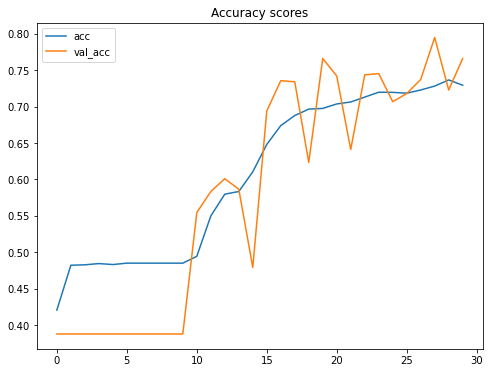

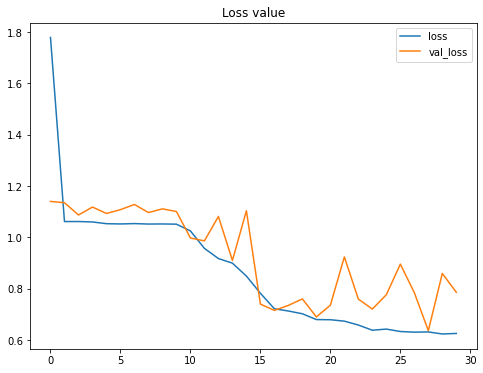

In [144]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [84]:
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(
  X_train, y_train_one_hot, test_size=0.2, random_state = 42)

In [118]:
vgg16 = VGG16(weights='imagenet', include_top=False)
hdf5_save = 'VGG16_Model.hdf5'
annealer = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.70, patience=5,
    verbose=1, min_lr=1e-4)
  
checkpoint = ModelCheckpoint(hdf5_save, verbose=1, save_best_only=True)
  
datagen2 = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
datagen2.fit(X_train)
train_gen2 = datagen.flow(X_train, y_train_one_hot, batch_size=32)



input = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
x = Conv2D(3, (3, 3), padding='same')(input)

x = vgg16(x)
  
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(3, activation='softmax', name='root')(x)
model2 = Model(input, output)
  
optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999,
                     epsilon=0.1, decay=0.0)
      
model2.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
      
model2.summary()
    
history = model2.fit_generator(train_gen2, epochs=30, validation_data=(X_test, y_test_one_hot))


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 200, 200, 3)       30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_12  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_21 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 512)               0  

C:\Users\anask\AppData\Local\Temp/ipykernel_17632/3426482288.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_gen2, epochs=30, validation_data=(X_test, y_test_one_hot))


131/131 [==============================] - 1419s 11s/step - loss: 1.4240 - accuracy: 0.4756 - val_loss: 18.0438 - val_accuracy: 0.2749
Epoch 2/30
131/131 [==============================] - 1403s 11s/step - loss: 1.1765 - accuracy: 0.5065 - val_loss: 6.8709 - val_accuracy: 0.3161
Epoch 3/30
131/131 [==============================] - 1496s 11s/step - loss: 0.9891 - accuracy: 0.5678 - val_loss: 1.0859 - val_accuracy: 0.5833
Epoch 4/30
131/131 [==============================] - 1416s 11s/step - loss: 0.9183 - accuracy: 0.5839 - val_loss: 0.8153 - val_accuracy: 0.6398
Epoch 5/30
131/131 [==============================] - 1316s 10s/step - loss: 0.8268 - accuracy: 0.6321 - val_loss: 2.2517 - val_accuracy: 0.4636
Epoch 6/30
131/131 [==============================] - 1391s 11s/step - loss: 0.7885 - accuracy: 0.6441 - val_loss: 0.8736 - val_accuracy: 0.5115
Epoch 7/30
131/131 [==============================] - 1427s 11s/step - loss: 0.7516 - accuracy: 0.6599 - val_loss: 1.9939 - val_accuracy: 0.

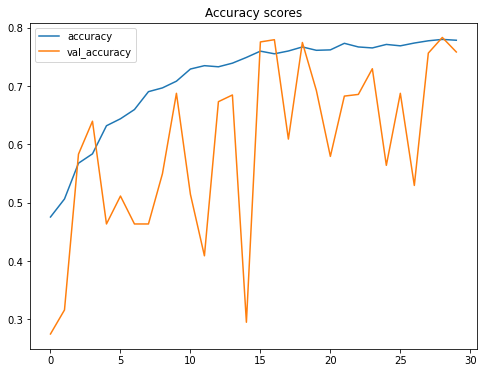

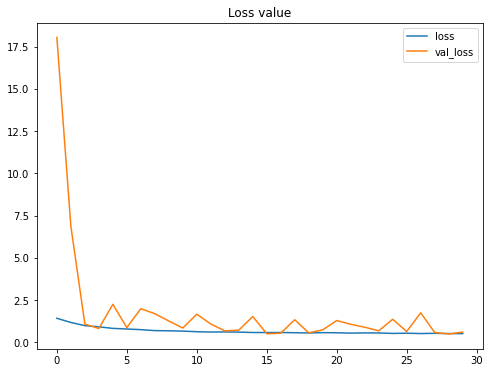

In [120]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()